# Resampling

## Crossvalidation and Bootstrapping

### Crossvalidation

In [1]:
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
import seaborn as sns

import statsmodels.api as sm

In [13]:
auto = pd.read_csv("Auto.csv")
auto = auto.query('horsepower != "?" ')
auto["horsepower"] = auto["horsepower"].astype(float)
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


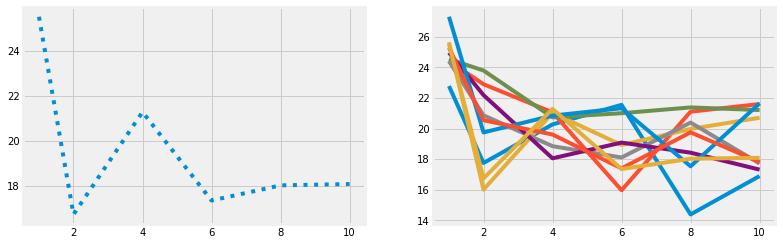

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

X = auto.filter(["horsepower"])
Y = auto.filter(["mpg"])


results = dict()

for iteration in range(1,10):
    mse = list()
    for degree in [1,2,4,6,8,10]:
        poly = PolynomialFeatures(degree=degree)
        poly = poly.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(poly,Y, test_size = 0.5)
        clf = LinearRegression()
        clf.fit(X_train,y_train)
        yhat = clf.predict(X_test)
        mse.append(mean_squared_error(y_test,yhat))
    results[str(iteration)] = mse

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))

xaxis = [1,2,4,6,8,10]
ax1.plot(xaxis,mse, linestyle=":")

for vals in results.values():
    ax2.plot(xaxis,vals)


### Leave-One-Out Cross-Validation (LOOCV)

In [158]:
from sklearn.model_selection import LeaveOneOut

X = np.array(auto.filter(["horsepower"]))
Y = np.array(auto.filter(["mpg"]))

loo = LeaveOneOut()
print(loo.get_n_splits(X))

392


The average MSE of the LOOCV is 24.23
The average MSE of the LOOCV is 19.25
The average MSE of the LOOCV is 19.42
The average MSE of the LOOCV is 18.97
The average MSE of the LOOCV is 19.22
The average MSE of the LOOCV is 18.95


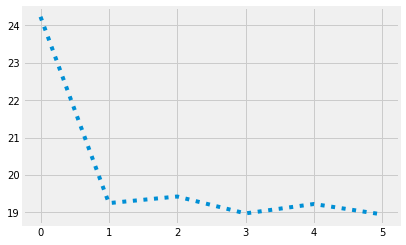

In [168]:
'''loo.split(X) gets the indices for all 392 iterations where X_test/y_test are only 1 sample'''

def LOOCV(X,Y):
    result = []
    deg = [1,2,4,6,8,10]
    for degree in deg:
        poly = PolynomialFeatures(degree=degree)
        poly = poly.fit_transform(X)
        mse = []
        for train_index, test_index in loo.split(poly):
            X_train, X_test, y_train, y_test = poly[train_index], poly[test_index], Y[train_index], Y[test_index]
            clf = LinearRegression()
            clf.fit(X_train,y_train)
            yhat = clf.predict(X_test)
            mse.append(mean_squared_error(y_test,yhat))
        print("The average MSE of the LOOCV is {0:.4}".format(np.mean(mse)))
        result.append(np.mean(mse))
    return result

plt.plot(LOOCV(X,Y), linestyle=":")
    

### k-Fold Cross-Validation

In [292]:
from sklearn.model_selection import KFold, StratifiedKFold

default = pd.read_csv("default.csv") # classification

kfold = KFold(n_splits=10, random_state=42, shuffle=
              True)
print(kfold.get_n_splits())

skfold = StratifiedKFold(n_splits=7, random_state=42, shuffle=True)
print(skfold.get_n_splits())

10
7


In [293]:
'''Regression using LinearRegression and KFold CV'''

X = np.array(auto.filter(["horsepower"]))
Y = np.array(auto.filter(["mpg"]))

def kfold_validation(X,Y):
    mse = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]
        clf = LinearRegression()
        clf.fit(X_train,y_train)
        yhat = clf.predict(X_test)
        mse.append(mean_squared_error(y_test,yhat)) #mse for each fold
    print("The average MSE of the KFold CV is {0:.4}".format(np.mean(mse)))
    return mse

mse = kfold_validation(X,Y)

The average MSE of the KFold CV is 24.2


In [301]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

skfold = StratifiedKFold(n_splits=7, random_state=42, shuffle=True)

X = np.array(default.filter(["income","balance"]))
Y = default.filter(["default"])
Y = Y["default"].apply(lambda x: 1.0 if x == "Yes" else 0.0)

def skfold_validation(X,Y,skfold,classifier):
    mse = []
    for train_index, test_index in skfold.split(X,Y):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]
        clf = classifier
        clf.fit(X_train,y_train)
        yhat = clf.predict(X_test)
        mse.append(roc_auc_score(y_test,yhat))
    print("The average MSE of the KFold CV is {0:.2%}".format(np.mean(mse)))
    return mse
mse = skfold_validation(X,Y,skfold, KNeighborsClassifier(n_neighbors=5))

The average MSE of the KFold CV is 57.12%


The average MSE of the KFold CV is 24.2
The average MSE of the KFold CV is 19.23
The average MSE of the KFold CV is 19.35
The average MSE of the KFold CV is 18.95
The average MSE of the KFold CV is 19.16
The average MSE of the KFold CV is 18.89
The average MSE of the LOOCV is 24.23
The average MSE of the LOOCV is 19.25
The average MSE of the LOOCV is 19.42
The average MSE of the LOOCV is 18.97
The average MSE of the LOOCV is 19.22
The average MSE of the LOOCV is 18.95


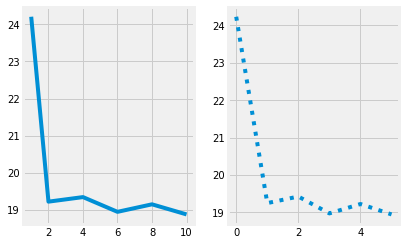

In [296]:
'''We can evaluate using CV which model fits best. Ie in the presence
of non-linearity we might wish to use polynomials '''

X = np.array(auto.filter(["horsepower"]))
Y = np.array(auto.filter(["mpg"]))

deg = [1,2,4,6,8,10]
mse = np.zeros((10,6))

i = 0
for degree in deg:
    poly = PolynomialFeatures(degree=degree)
    poly = poly.fit_transform(X)
    temp = kfold_validation(poly,Y) # array of 10 CVs
    mse[:,i] = temp 
    i += 1


fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(deg,np.mean(mse, axis=0))    
ax2.plot(LOOCV(X,Y), linestyle=":")

The average MSE of the KFold CV is 61.44%
The average MSE of the KFold CV is 78.12%
The average MSE of the KFold CV is 75.73%
The average MSE of the KFold CV is 75.61%
The average MSE of the KFold CV is 75.64%
The average MSE of the KFold CV is 74.80%
The average MSE of the KFold CV is 56.74%
The average MSE of the KFold CV is 56.01%
The average MSE of the KFold CV is 54.87%
The average MSE of the KFold CV is 54.13%
The average MSE of the KFold CV is 53.12%
The average MSE of the KFold CV is 50.75%
The average MSE of the KFold CV is 50.00%
The average MSE of the KFold CV is 50.00%


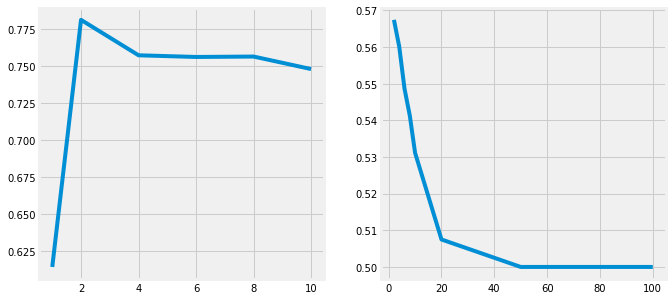

In [303]:
X = np.array(default.filter(["income","balance"]))
Y = default.filter(["default"])
Y = Y["default"].apply(lambda x: 1.0 if x == "Yes" else 0.0)

deg = [1,2,4,6,8,10]
mse = []

skfold = StratifiedKFold(n_splits=7, 
                         random_state=42, 
                         shuffle=True) 
i = 0
for degree in deg:
    poly = PolynomialFeatures(degree=degree)
    poly = poly.fit_transform(X)
    temp = skfold_validation(poly,Y,skfold, LinearDiscriminantAnalysis()) # array of 10 CVs
    mse.append(np.mean(temp))
   
    
mse_knn = []
knn = [2,4,6,8,10,20,50,100]
for KNN in knn:
    temp = skfold_validation(X,Y,skfold,KNeighborsClassifier(n_neighbors = KNN))
    mse_knn.append(np.mean(temp))
    
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(deg,mse)
ax2.plot(knn, mse_knn)
    